In [84]:
import os
import argparse
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline


def timestr_to_min(timestr):
    timestr = timestr.strip()
    h, m, s = timestr.split()
    h = float(h[:-1])
    m = float(m[:-1])
    m = h * 60 + m
    return m


def timestr_to_hour(timestr):
    timestr = timestr.strip()
    h, m, s = timestr.split()
    h = float(h[:-1])
    m = float(m[:-1])
    m = h + m / 60
    return m


def numstr_to_num(numstr):
    numstr = numstr.strip()
    num = float(numstr[:-1])
    unit = numstr[-1]
    if unit == 'M':
        return num * 1e6
    if unit == 'K':
        return num * 1e3


def moving_average(data, period):
    # padding
    left_pad = [data[0] for _ in range(period // 2)]
    right_pad = data[-period // 2 + 1 :]
    data = left_pad + data + right_pad
    weights = np.ones(period) / period
    return np.convolve(data, weights, mode='valid')


def parse_log(path):
    perf = []
    time = []
    sample = []
    f = open(path, 'r').readlines()
    for l in f:
        if 'eval score' in l:
            score = float(l.split()[-1])
            perf.append(score)
        if 'total time(train)' in l:
            t = l.split(':')[-1]
            time.append(timestr_to_hour(t))
            if timestr_to_hour(t) >= 20:
                break
        if 'Total Sample' in l:
            s = l.split()[-1]
            sample.append(numstr_to_num(s) / 1e6)
    time = time[:len(perf)]
    sample = sample[:len(perf)]
    return time, sample, perf


def parse_folder(folder):
    paths = [os.path.join(folder, p, 'train.log') for p in os.listdir(folder)]
    paths = [p for p in paths if os.path.exists(p)]
    logs = defaultdict(list)
    for p in paths:
        name = p.split('/')[-2]
        logs[name] = parse_log(p)
    return logs


def factor_n(n):
    k = int(np.sqrt(n))
    for i in range(k, 0, -1):
        if n % i == 0:
            return i, n // i
    return


def get_game_name(name):
    name = name.replace('ms_pacman', 'pacman')
    configs = name.split('_')
    for c in configs:
        if c.startswith('GAME'):
            return c[4:]
    return


def filter_logs(logs, filter_strings):
    f_logs = {}
    for k in logs:
        include = True
        for s in filter_strings:
            if s not in k:
                include = False
                break
        if include:
            f_logs[k] = logs[k]
    return f_logs


def render_folder(folder, xtype, filter_strings=[], smooth_k=51):
    logs = parse_folder(folder)
    if filter_strings:
        logs = filter_logs(logs, filter_strings)
            
    print('rendering %d logs' %  len(logs))
    row, col = factor_n(len(logs))
    # for xtype in ['epoch', 'time', 'samples']:
    print('W.R.T %s' % xtype)
    fig, axes = plt.subplots(row, col, figsize=(8 * col, 8 * row))
    if row == 1:
        axes = [axes]
    for i, name in enumerate(sorted(logs.keys())):
        t, s, perf = logs[name]
        if len(s) == 0:
            print('bad log:', name)
            continue
        perf = moving_average(perf, smooth_k)
        r = i // col
        c = i % col
        if xtype == 'epoch':
            x = range(len(perf))
        elif xtype == 'time':
            x = t
        elif xtype == 'samples':
            x = s
        axes[r][c].plot(x, perf)
        axes[r][c].set_title(get_game_name(name))
    plt.show()
    return


def render_cmp(files, xtype, smooth_k, get_name, max_l, title):
    logs = {}
    for f in files:
#        if 'sweep' in f:
#            name = '%s' % (f.split('/')[-3])
#        else:
#            name = '%s' % (f.split('/')[-2])
        name = get_name(f)
        logs[name] = parse_log(f)
    fig, axes = plt.subplots(1, 1, figsize=(12, 10))
    print(logs.keys())
    for name in sorted(logs.keys()):
        t, s, perf = logs[name]
        perf = moving_average(perf, smooth_k)
        if xtype == 'epoch':
            x = range(len(perf))
        elif xtype == 'time':
            x = t
        elif xtype == 'samples':
            x = s
        #print(x)
        #print(perf)
        if max_l > 0:
            x = x[:max_l]
            perf = perf[:max_l]
        if len(x) != len(perf):
            print('warning: too short: ', name)
            continue            
        axes.plot(x, perf, label=name)
#    plt.axhline(y=ref1)
#    plt.axhline(y=ref2)
    axes.set_xlim(0, 20)
    axes.set_title(title)
    plt.legend(loc='upper left', prop={'size': 25})
    plt.show()
    return


GAME: asterix
dict_keys(['apex', 'r2d2'])


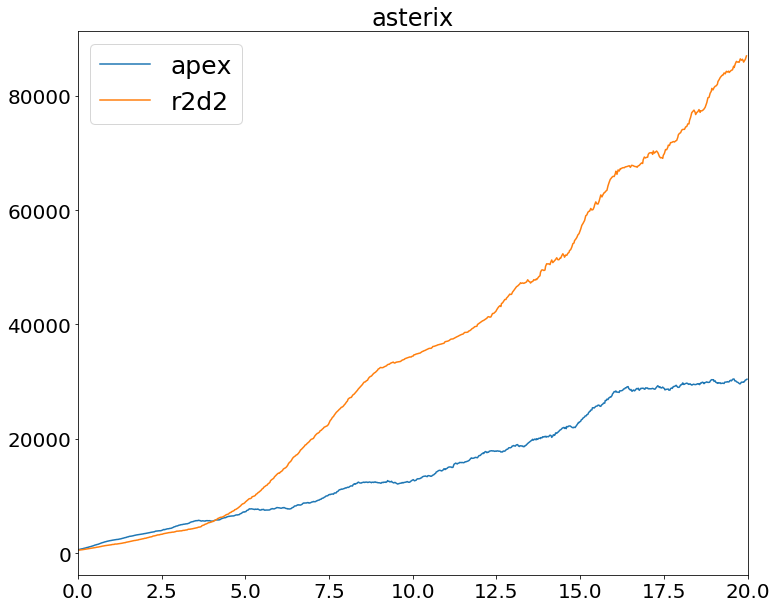

GAME: asteroids
dict_keys(['apex', 'r2d2'])


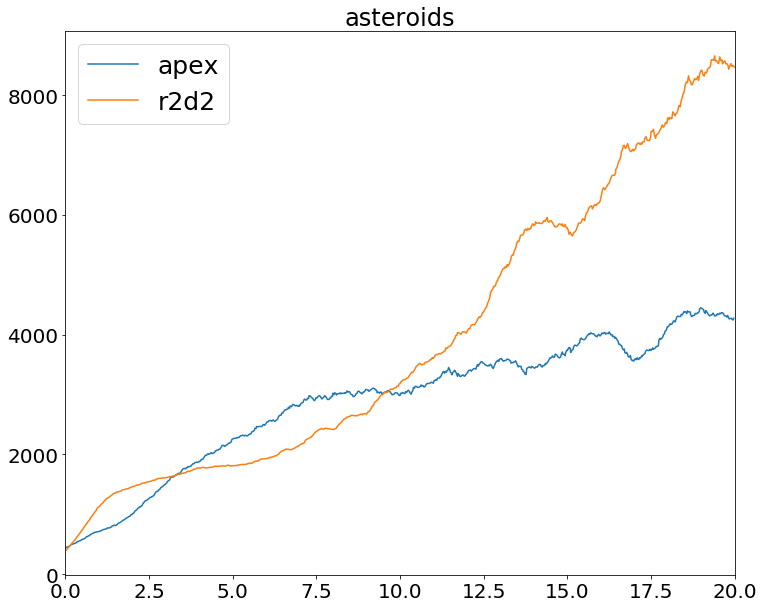

GAME: gravitar
dict_keys(['apex', 'r2d2'])


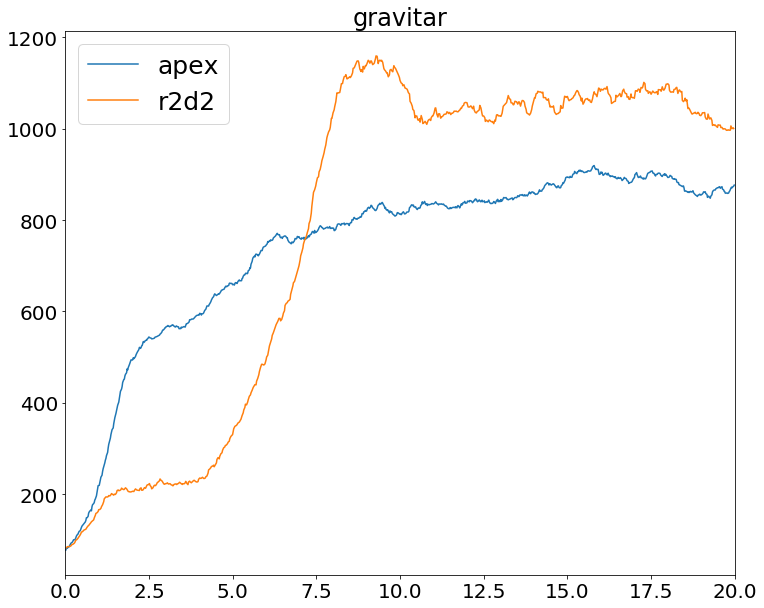

GAME: ms_pacman
dict_keys(['apex', 'r2d2'])


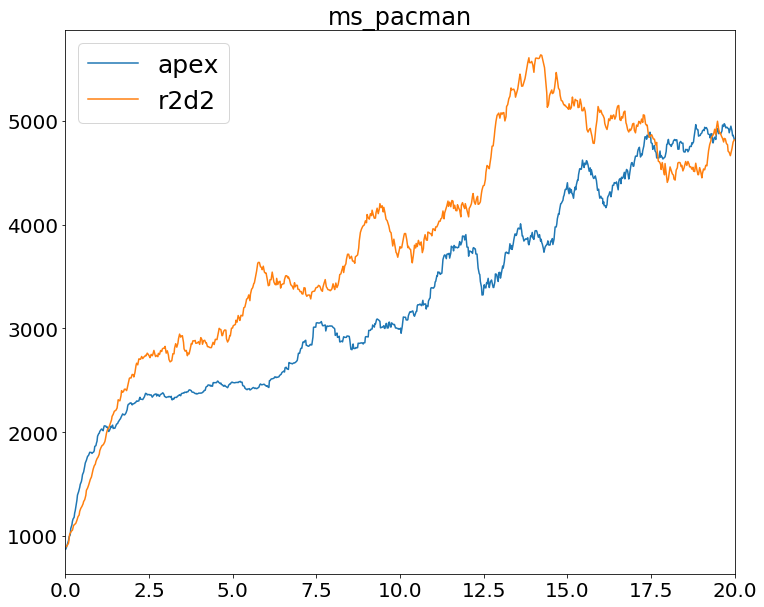

GAME: qbert
dict_keys(['apex', 'r2d2'])


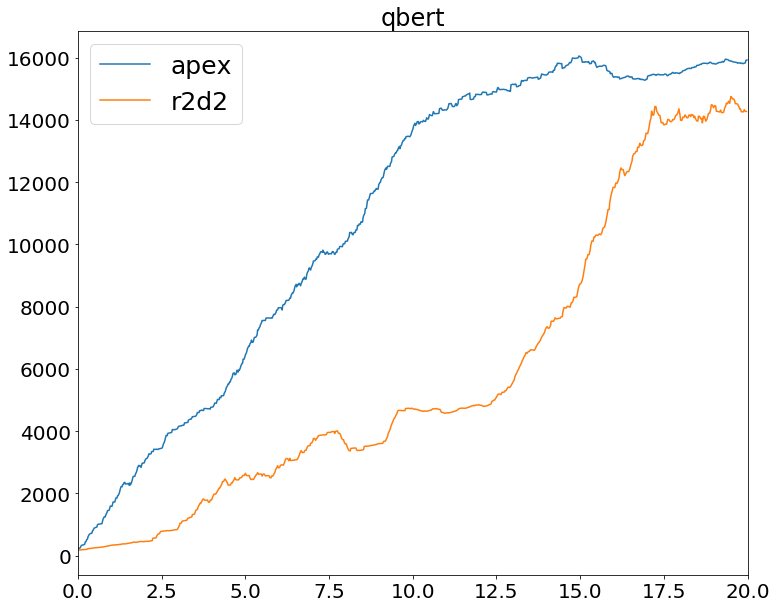

GAME: seaquest
dict_keys(['apex', 'r2d2'])


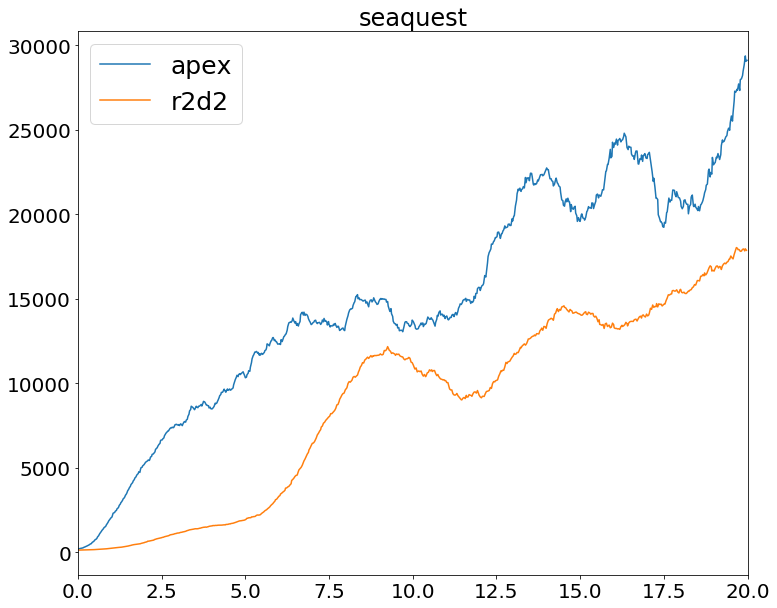

In [85]:
def get_name(f):
    if 'apex' in f:
        return 'apex'
    else:
        return 'r2d2'
    return f.split('/')[-2]


dqn_perf = {
    'asterix': 428200 / 3,
    'asteroids': 2712 / 4,
    'gravitar': 1419 / 6,
    'ms_pacman': 6283 / 3,
    'qbert': 33817 / 4,
    'seaquest': 50254 / 4,
}

apex_perf = {
    'asterix': 313305 / 3,
    'asteroids': 155495 / 4,
    'gravitar': 1598 / 6,
    'ms_pacman': 11255 / 3,
    'qbert': 302391 / 4,
    'seaquest': 392952 / 4,
}

plt.rcParams.update({'font.size': 20})
for game in ['asterix', 'asteroids', 'gravitar', 'ms_pacman', 'qbert', 'seaquest']:
    if game in ['seaquest',  'qbert']:
        logs = [
            '/private/home/hengyuan/rela/pyrela/sweep2/apex_newnet2/GAME%s/train.log',
            '/private/home/hengyuan/rela/pyrela/sweep2/r2d2_newnet2/GAME%s_SAME_HID0_LR0.0001_EPS1e-07/train.log',
        ]
    else:
        logs = [
            '/private/home/hengyuan/rela/pyrela/sweep2/apex_newnet2/GAME%s/train.log',
            '/private/home/hengyuan/rela/pyrela/sweep2/r2d2_newnet2/GAME%s_SAME_HID0_LR0.001_EPS1e-07/train.log',
        ]
#    logs = [
#        '/private/home/hengyuan/rela/pyrela/sweep2/apex_newnet2/GAME%s/train.log',
#        '/private/home/hengyuan/rela/pyrela/sweep2/r2d2_newnet2/GAME%s_SAME_HID0_LR0.001_EPS1e-07/train.log',
#        '/private/home/hengyuan/rela/pyrela/sweep2/r2d2_newnet2/GAME%s_SAME_HID0_LR0.0001_EPS1e-07/train.log',
#    ]
    print('GAME:', game)
    for i in range(len(logs)):
        logs[i] = logs[i] % game
    render_cmp(logs, 'time', 51, get_name, -1, game)

GAME: asteroids
dict_keys(['GAMEasteroids_MULTI_STEP3', 'GAMEasteroids_SAME_HID0_LR0.0001_EPS1e-07'])


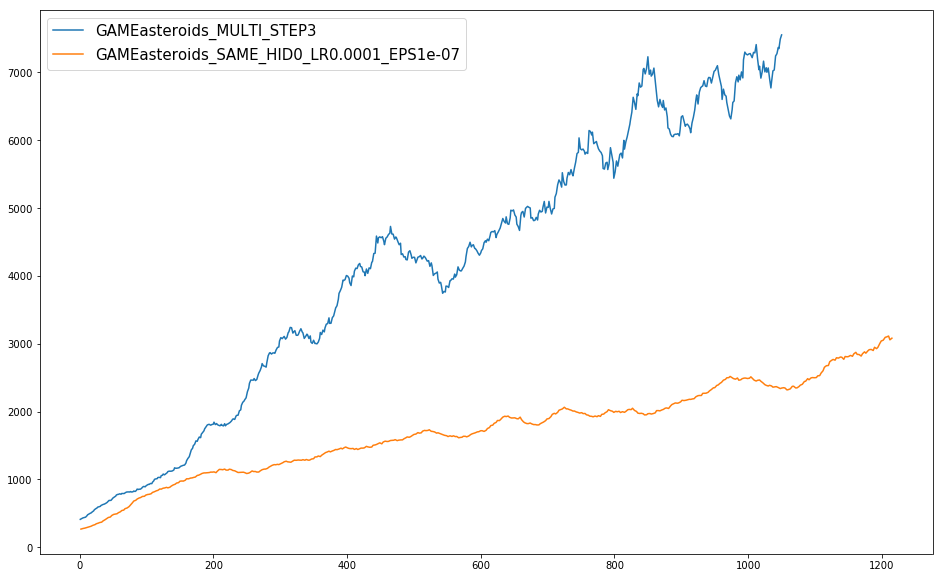

GAME: bowling
dict_keys(['GAMEbowling_MULTI_STEP3', 'GAMEbowling_SAME_HID0_LR0.0001_EPS1e-07'])


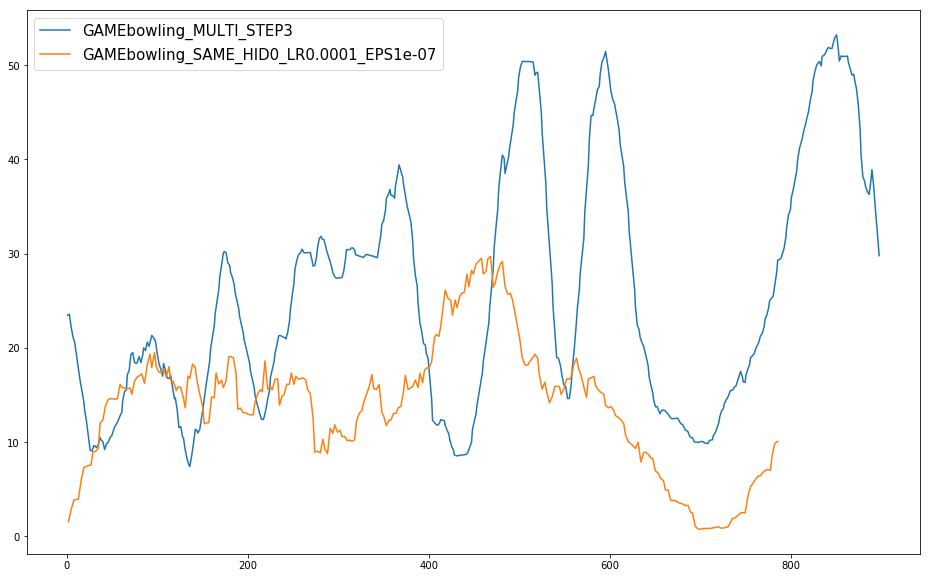

GAME: gravitar
dict_keys(['GAMEgravitar_MULTI_STEP3', 'GAMEgravitar_SAME_HID0_LR0.0001_EPS1e-07'])


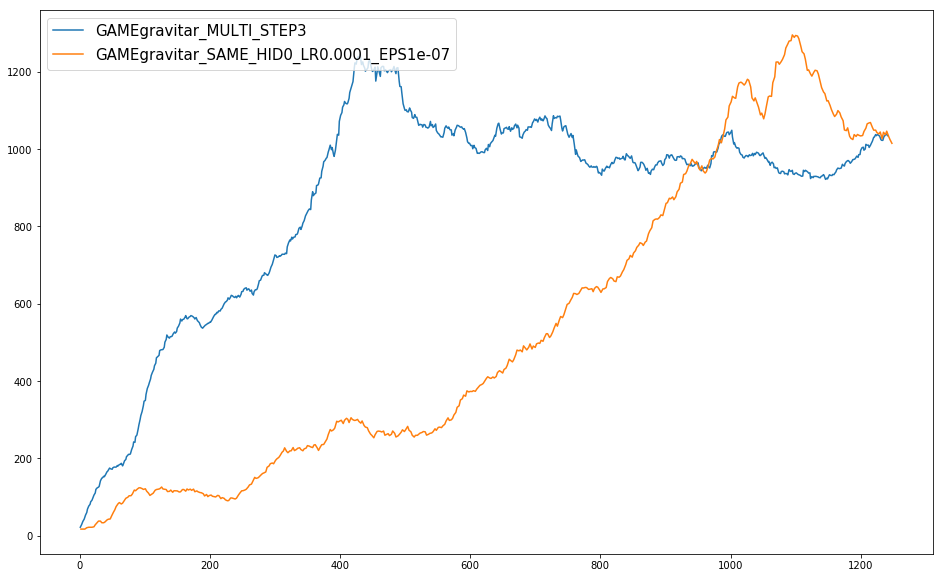

GAME: ms_pacman
dict_keys(['GAMEms_pacman_MULTI_STEP3', 'GAMEms_pacman_SAME_HID0_LR0.0001_EPS1e-07'])


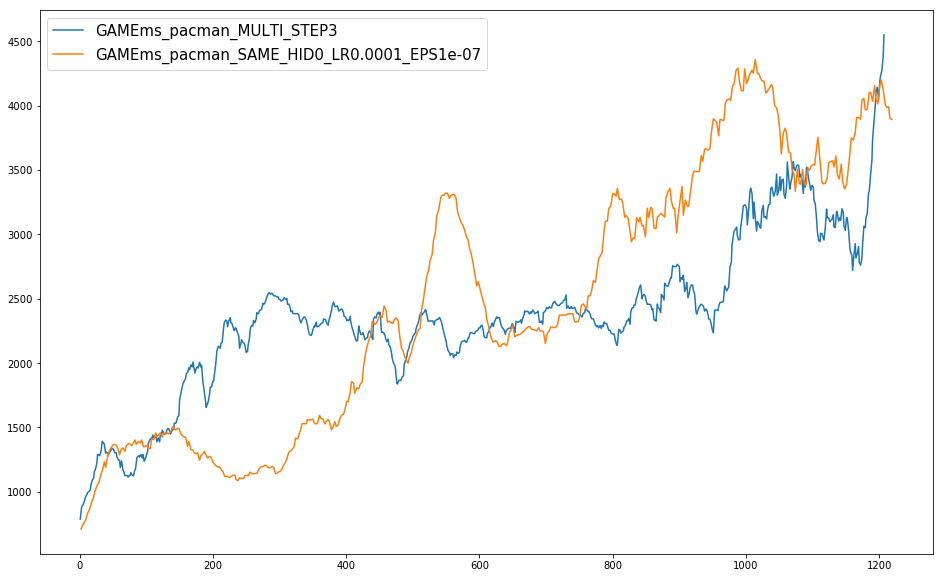

GAME: seaquest
dict_keys(['GAMEseaquest_MULTI_STEP3', 'GAMEseaquest_SAME_HID0_LR0.0001_EPS1e-07'])


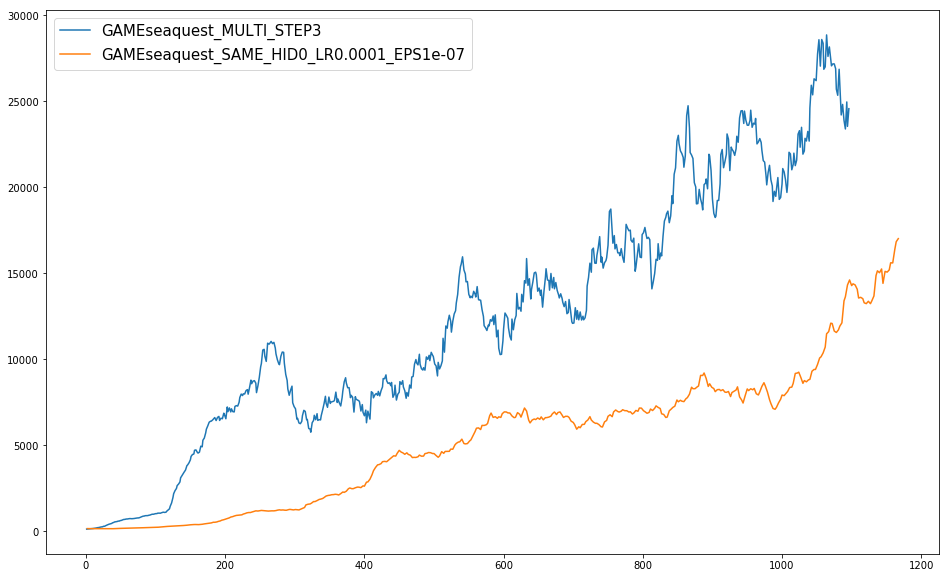

In [24]:
def get_name(f):
    return f.split('/')[-2]


for game in ['asteroids', 'bowling', 'gravitar', 'ms_pacman', 'seaquest']:
    logs = [
        '/private/home/hengyuan/rela/pyrela/sweep2/apex_newnet/GAME%s_MULTI_STEP3/train.log',
#        '/private/home/hengyuan/rela/pyrela/sweep2/r2d2_newnet/GAME%s_SAME_HID0_LR0.0001_EPS0.001/train.log',
#        '/private/home/hengyuan/rela/pyrela/sweep2/r2d2_newnet/GAME%s_SAME_HID0_LR0.0001_EPS1e-05/train.log',
        '/private/home/hengyuan/rela/pyrela/sweep2/r2d2_newnet/GAME%s_SAME_HID0_LR0.0001_EPS1e-07/train.log',
    ]
    print('GAME:', game)
    for i in range(len(logs)):
        logs[i] = logs[i] % game
    render_cmp(logs, 'time', 21, get_name, -1)

In [ ]:
def get_name(f):
    return f.split('/')[-3]


for game in ['asteroids', 'bowling', 'gravitar', 'ms_pacman', 'seaquest']:
    logs = [
        '/private/home/hengyuan/rela/pyrela/sweep2/apex_onelife/GAME%s_MULTI_STEP3/train.log',
        '/private/home/hengyuan/rela/pyrela/sweep2/apex_newnet/GAME%s_MULTI_STEP3/train.log',
    ]
    print('GAME:', game)
    for i in range(len(logs)):
        logs[i] = logs[i] % game
    render_cmp(logs, 'time', 21, get_name, -1)

rendering 5 logs
W.R.T epoch


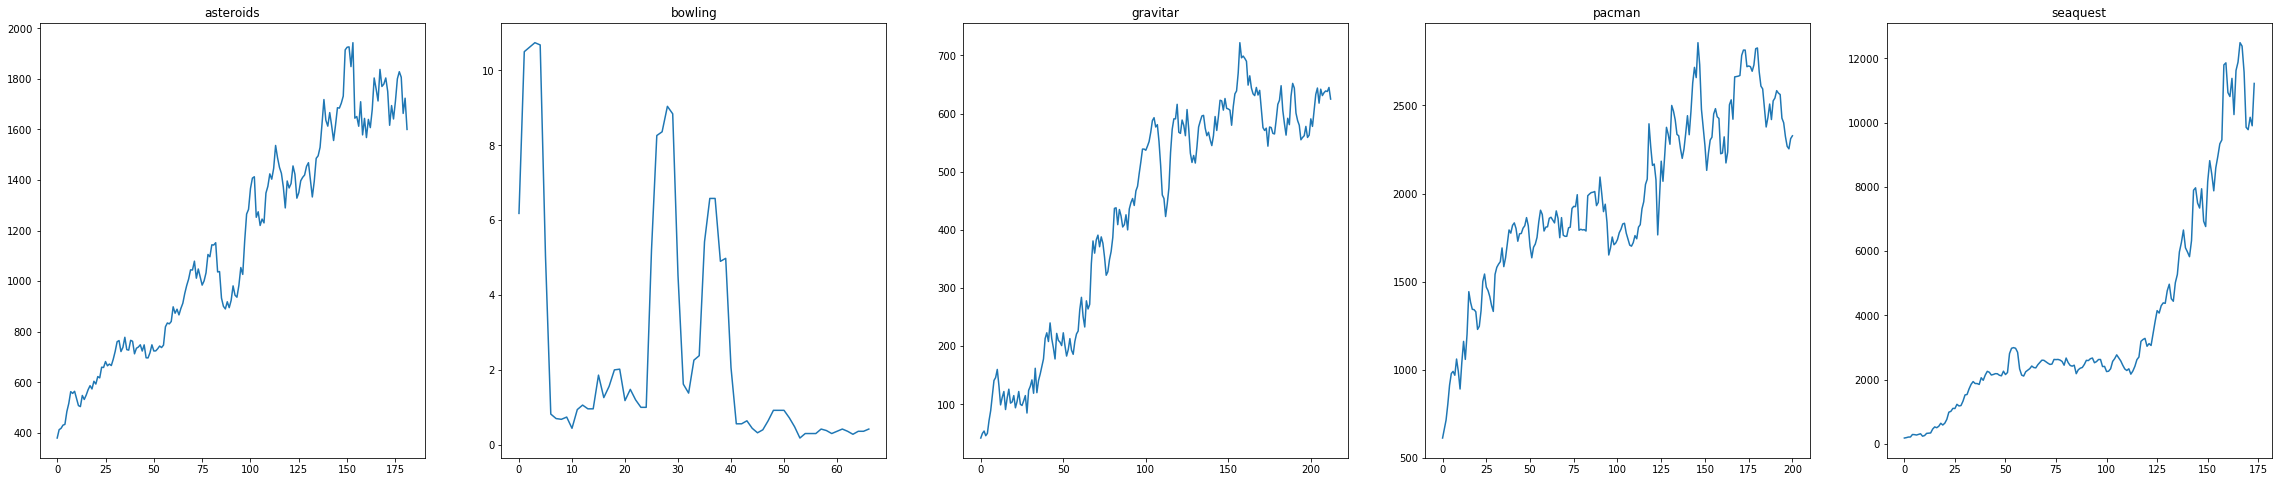

In [232]:
# render_folder('/private/home/hengyuan/rela/pyrela/sweep/apex', 'epoch')
# render_folder('/private/home/hengyuan/rela/pyrela/sweep/apex', 'time')
render_folder('/private/home/hengyuan/rela/pyrela/sweep/apex_onelife', 'epoch', [], 5)

GAME: asteroids
dict_keys(['MULTI_STEP1', 'MULTI_STEP3', 'MULTI_STEP5'])


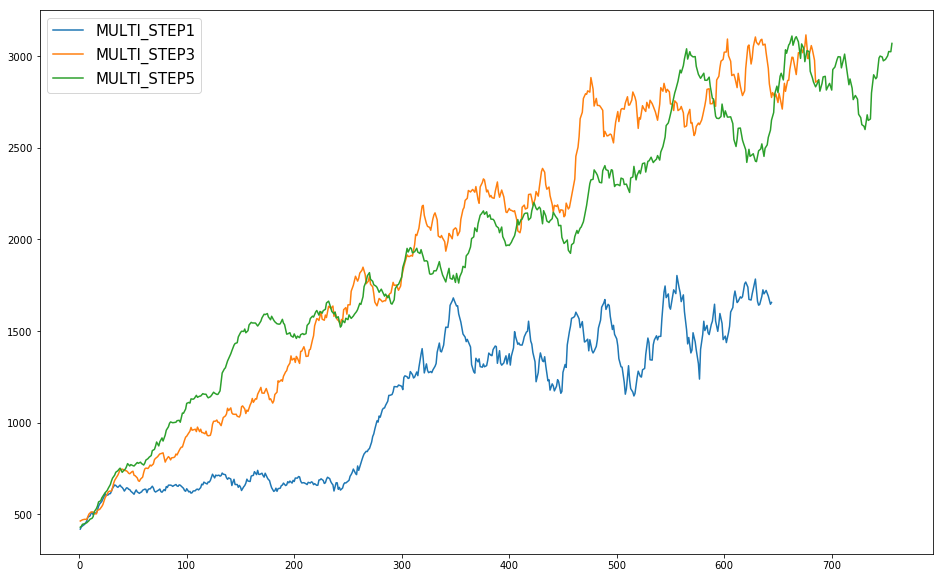

GAME: bowling
dict_keys(['MULTI_STEP1', 'MULTI_STEP3', 'MULTI_STEP5'])


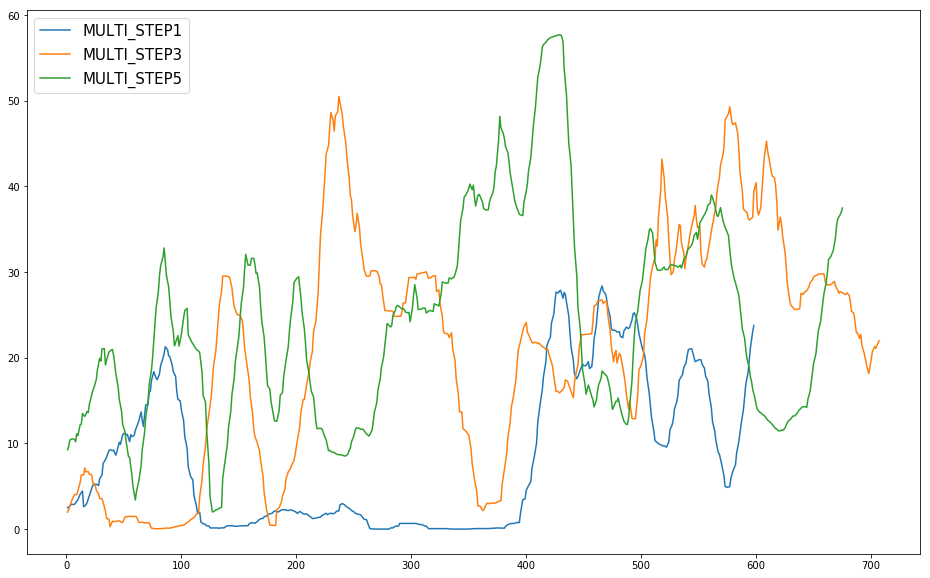

GAME: gravitar
dict_keys(['MULTI_STEP1', 'MULTI_STEP3', 'MULTI_STEP5'])


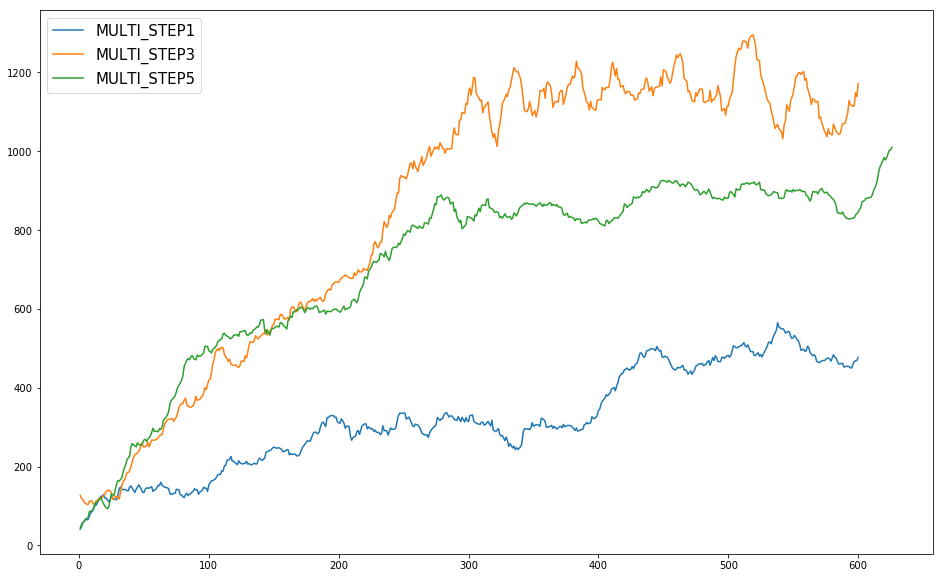

GAME: ms_pacman
dict_keys(['MULTI_STEP1', 'MULTI_STEP3', 'MULTI_STEP5'])


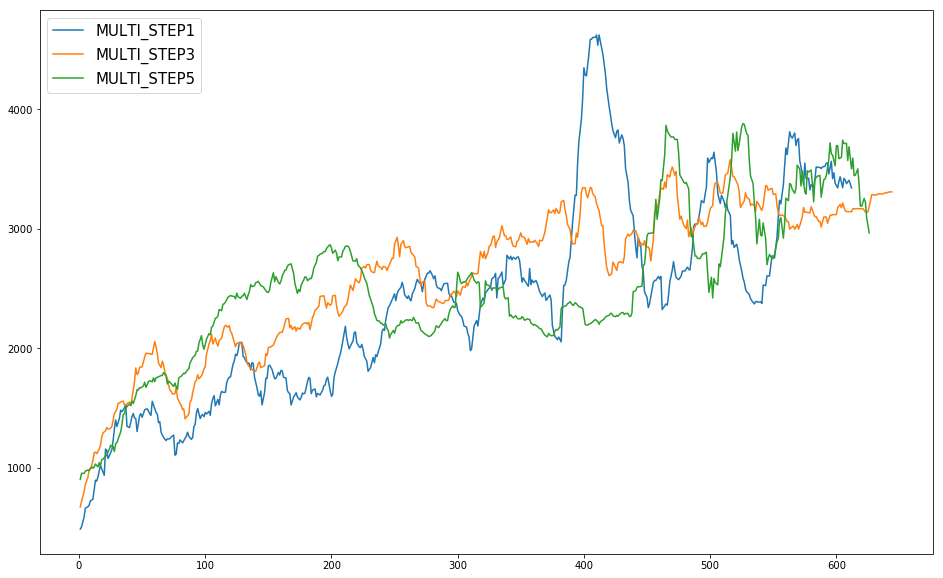

GAME: seaquest
dict_keys(['MULTI_STEP1', 'MULTI_STEP3', 'MULTI_STEP5'])


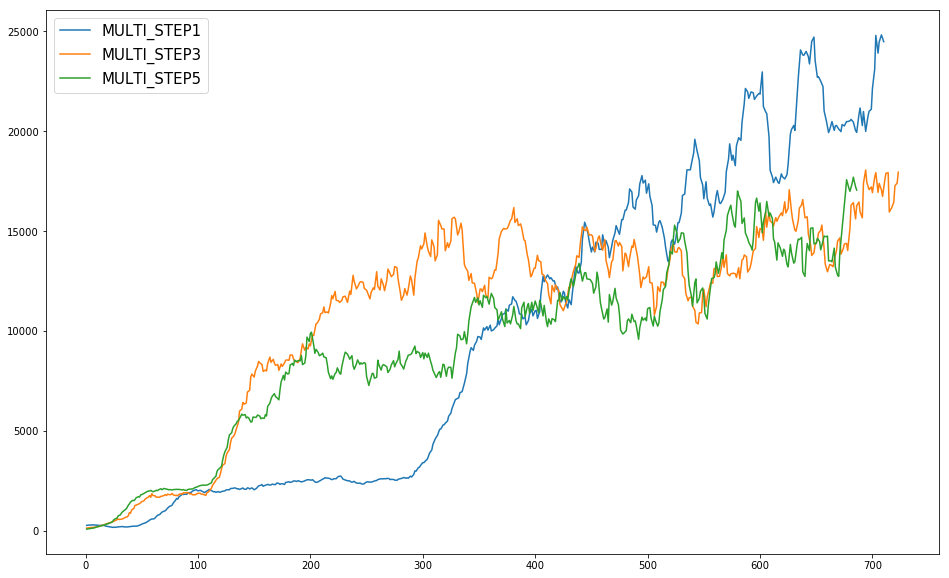

In [13]:
def get_name(f):
    return f.split('/')[-2][-len('MULTI_STEP1'):]

for game in ['asteroids', 'bowling', 'gravitar', 'ms_pacman', 'seaquest']:
    logs = [
        '/private/home/hengyuan/rela/pyrela/sweep2/apex_onelife/GAME%s_MULTI_STEP1/train.log',
        '/private/home/hengyuan/rela/pyrela/sweep2/apex_onelife/GAME%s_MULTI_STEP3/train.log',
        '/private/home/hengyuan/rela/pyrela/sweep2/apex_onelife/GAME%s_MULTI_STEP5/train.log',
    ]
    print('GAME:', game)
    for i in range(len(logs)):
        logs[i] = logs[i] % game
    render_cmp(logs, 'time', 15, get_name, 500)

GAME: asteroids
dict_keys(['GAMEasteroids_MULTI_STEP3', 'GAMEasteroids_SAME_HID0_LR0.0001', 'GAMEasteroids_SAME_HID1_LR0.0001'])


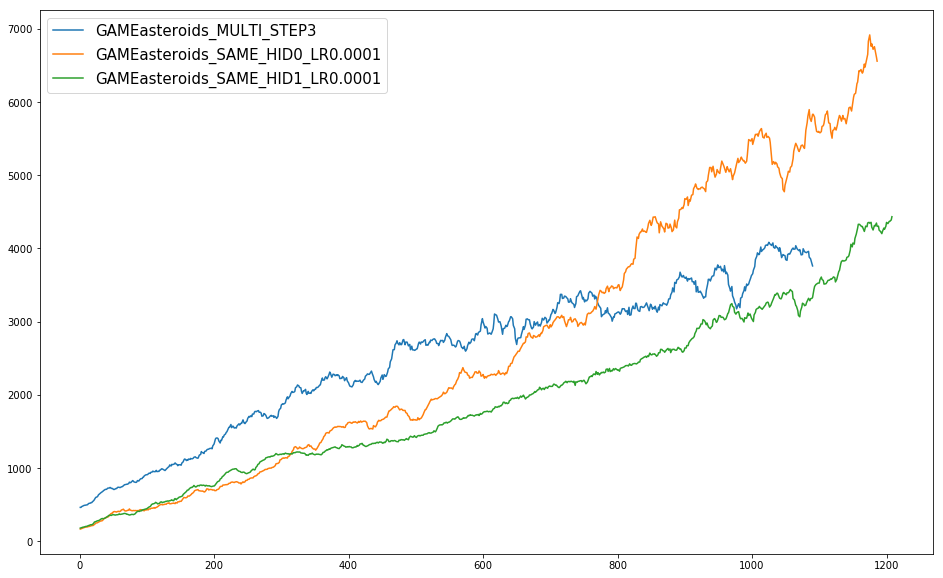

GAME: bowling
dict_keys(['GAMEbowling_MULTI_STEP3', 'GAMEbowling_SAME_HID0_LR0.0001', 'GAMEbowling_SAME_HID1_LR0.0001'])


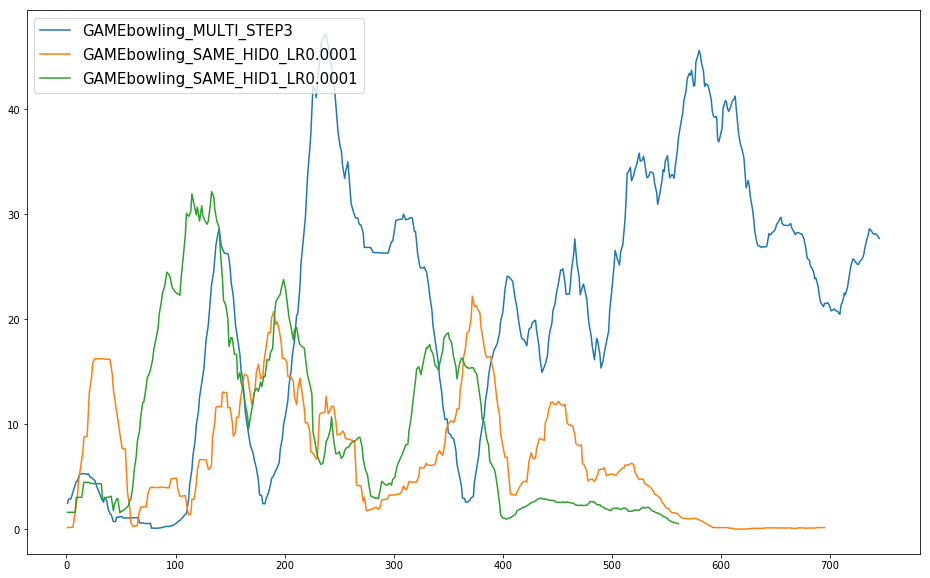

GAME: gravitar
dict_keys(['GAMEgravitar_MULTI_STEP3', 'GAMEgravitar_SAME_HID0_LR0.0001', 'GAMEgravitar_SAME_HID1_LR0.0001'])


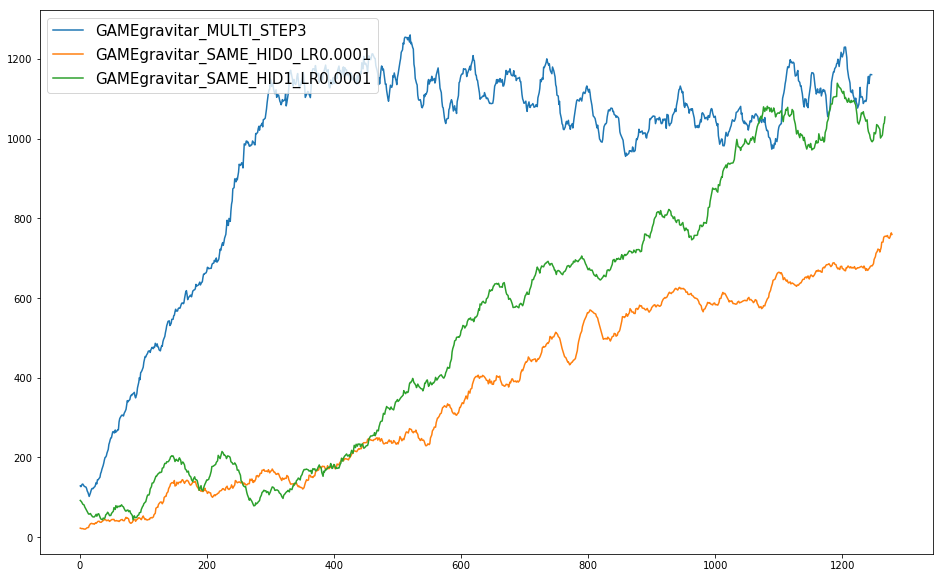

GAME: ms_pacman
dict_keys(['GAMEms_pacman_MULTI_STEP3', 'GAMEms_pacman_SAME_HID0_LR0.0001', 'GAMEms_pacman_SAME_HID1_LR0.0001'])


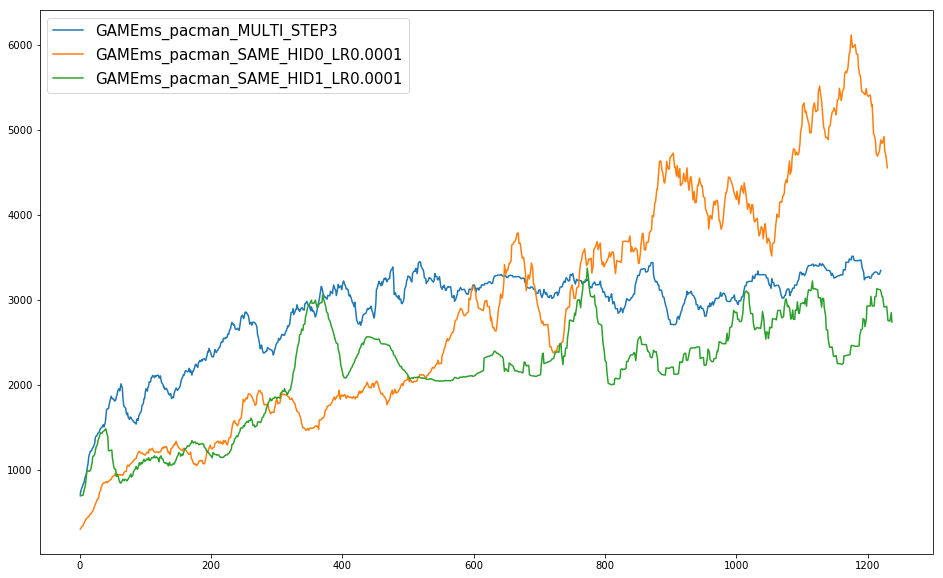

GAME: seaquest
dict_keys(['GAMEseaquest_MULTI_STEP3', 'GAMEseaquest_SAME_HID0_LR0.0001', 'GAMEseaquest_SAME_HID1_LR0.0001'])


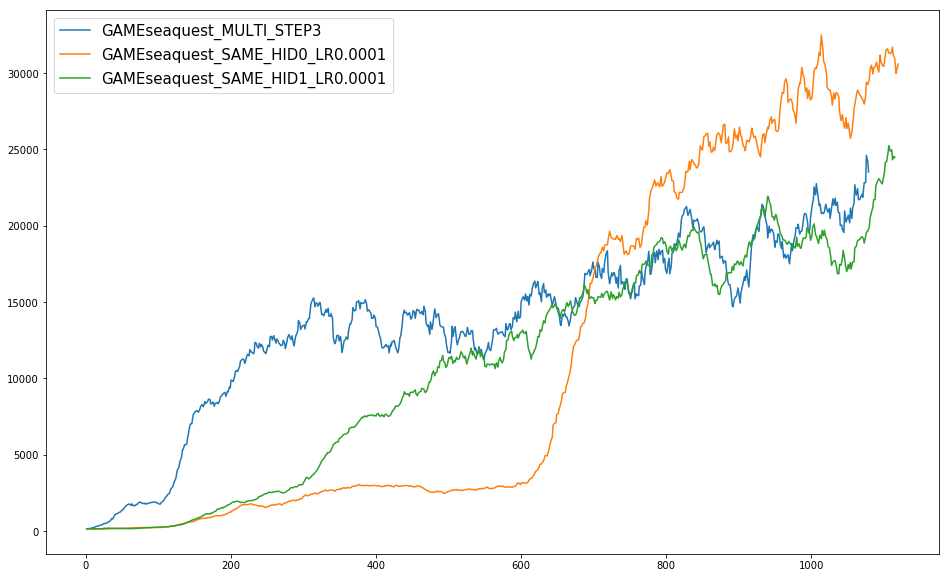

In [10]:
def get_name(f):
    return f.split('/')[-2]


for game in ['asteroids', 'bowling', 'gravitar', 'ms_pacman', 'seaquest']:
    logs = [
        '/private/home/hengyuan/rela/pyrela/sweep2/apex_onelife/GAME%s_MULTI_STEP3/train.log',
        '/private/home/hengyuan/rela/pyrela/sweep2/r2d2_onelife/GAME%s_SAME_HID0_LR0.0001/train.log',
#        '/private/home/hengyuan/rela/pyrela/sweep2/r2d2_onelife/GAME%s_SAME_HID0_LR1.25e-06/train.log',
#        '/private/home/hengyuan/rela/pyrela/sweep2/r2d2_onelife/GAME%s_SAME_HID0_LR1e-05/train.log',
        '/private/home/hengyuan/rela/pyrela/sweep2/r2d2_onelife/GAME%s_SAME_HID1_LR0.0001/train.log',
#        '/private/home/hengyuan/rela/pyrela/sweep2/r2d2_onelife/GAME%s_SAME_HID1_LR1.25e-06/train.log',
#        '/private/home/hengyuan/rela/pyrela/sweep2/r2d2_onelife/GAME%s_SAME_HID1_LR1e-05/train.log',
    ]
    print('GAME:', game)
    for i in range(len(logs)):
        logs[i] = logs[i] % game
    render_cmp(logs, 'time', 21, get_name, -1)

GAME: asteroids
dict_keys(['GAMEasteroids_MULTI_STEP3', 'GAMEasteroids_SAME_HID0', 'GAMEasteroids_SAME_HID1'])


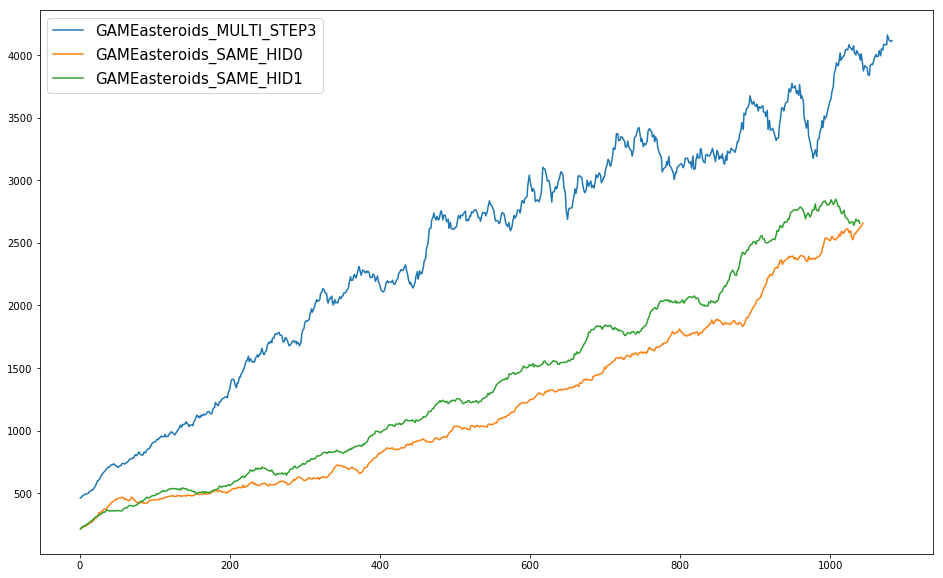

GAME: bowling
dict_keys(['GAMEbowling_MULTI_STEP3', 'GAMEbowling_SAME_HID0', 'GAMEbowling_SAME_HID1'])


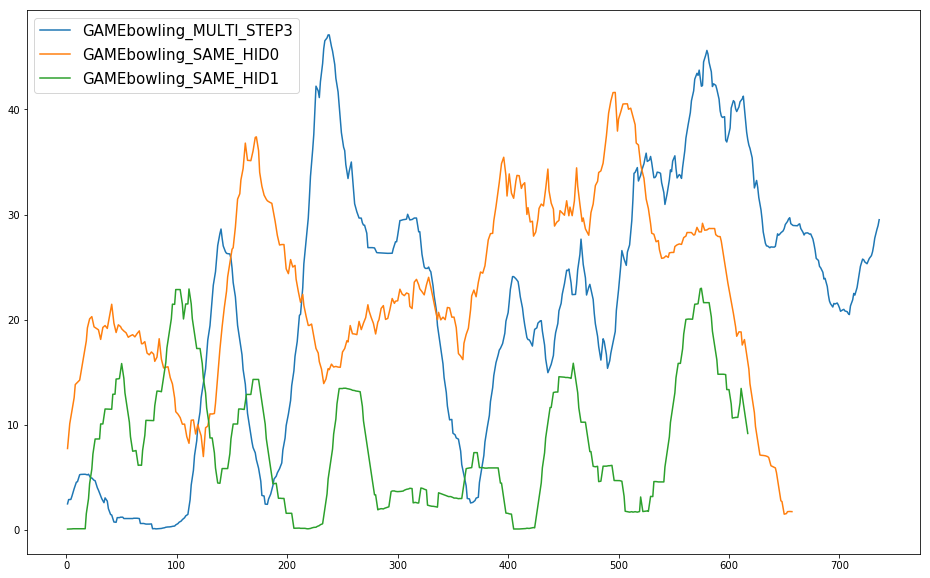

GAME: gravitar
dict_keys(['GAMEgravitar_MULTI_STEP3', 'GAMEgravitar_SAME_HID0', 'GAMEgravitar_SAME_HID1'])


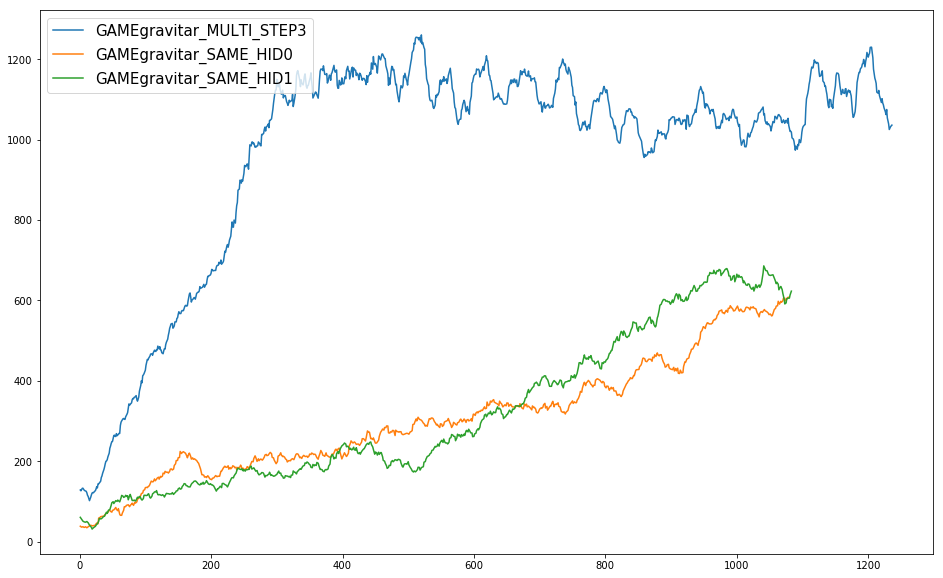

GAME: ms_pacman
dict_keys(['GAMEms_pacman_MULTI_STEP3', 'GAMEms_pacman_SAME_HID0', 'GAMEms_pacman_SAME_HID1'])


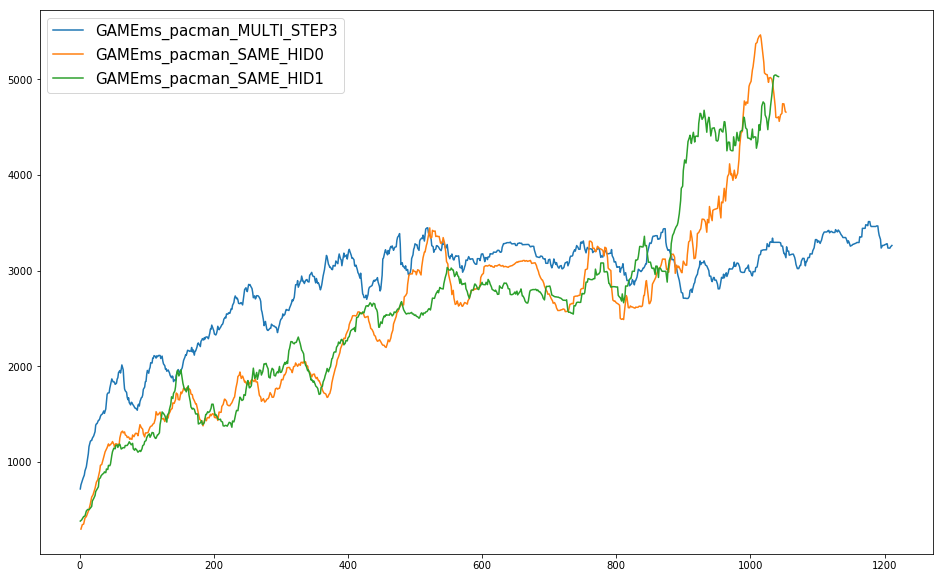

GAME: seaquest
dict_keys(['GAMEseaquest_MULTI_STEP3', 'GAMEseaquest_SAME_HID0', 'GAMEseaquest_SAME_HID1'])


IndexError: list index out of range

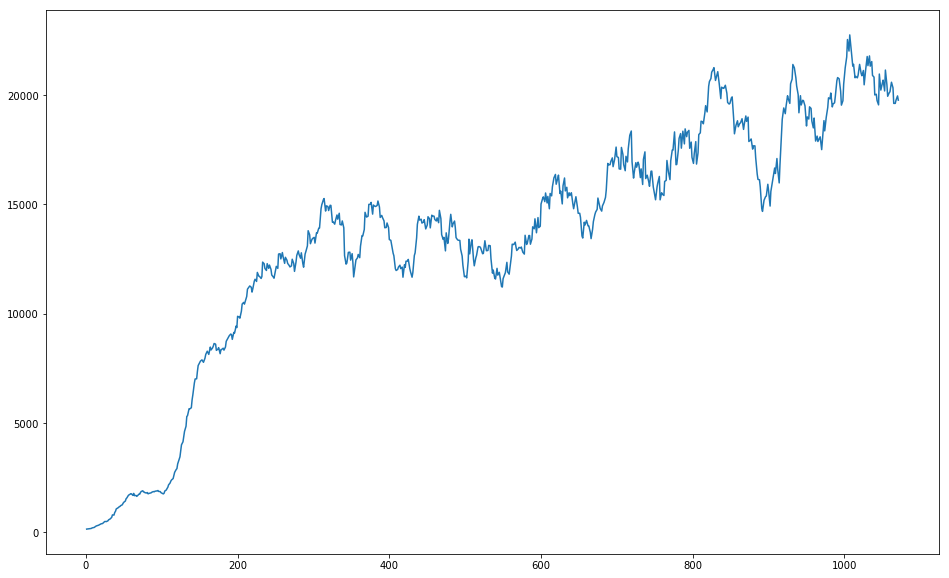

In [231]:
def get_name(f):
    return f.split('/')[-2]


for game in ['asteroids', 'bowling', 'gravitar', 'ms_pacman', 'seaquest']:
    logs = [
        '/private/home/hengyuan/rela/pyrela/sweep2/apex_onelife/GAME%s_MULTI_STEP3/train.log',
        '/private/home/hengyuan/rela/pyrela/sweep2/r2d2_onelife_net/GAME%s_SAME_HID0/train.log',
#        '/private/home/hengyuan/rela/pyrela/sweep2/r2d2_onelife/GAME%s_SAME_HID0_LR1.25e-06/train.log',
#        '/private/home/hengyuan/rela/pyrela/sweep2/r2d2_onelife/GAME%s_SAME_HID0_LR1e-05/train.log',
        '/private/home/hengyuan/rela/pyrela/sweep2/r2d2_onelife_net/GAME%s_SAME_HID1/train.log',
#        '/private/home/hengyuan/rela/pyrela/sweep2/r2d2_onelife/GAME%s_SAME_HID1_LR1.25e-06/train.log',
#        '/private/home/hengyuan/rela/pyrela/sweep2/r2d2_onelife/GAME%s_SAME_HID1_LR1e-05/train.log',
    ]
    print('GAME:', game)
    for i in range(len(logs)):
        logs[i] = logs[i] % game
    render_cmp(logs, 'time', 21, get_name, -1)